# Kmeans Clustering

**KMeans runs quickly (O(n)) but does not handle elongated clusters or non linear data well AND you have to specify the number of clusters up front (how would you possibly know this?). AND it is vulnerable to outliers because it will insist on placing them in a cluster** <br>
The following illustrates a sample kmeans implementation to show the algorithm in action. For practical problems, use the kmeans implementation in scikitlearn (see the bottom of this notebook for sample code)

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('default')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

## Constants and Functions

In [75]:
NUMB_SAMPLES=500
K_CLUSTERS = 3

# used for custom color palette below
colors1 = {-1:"brown",
            0:"cyan",
           1:"orange", 
           2:"purple"}

# RANDOM_STATE=7  #7 generates bad clusters because the initial points cluster centers were chosen poorly 
RANDOM_STATE=999  # this will choose better for this problem (kmeans++ does a good job of solving this problem, see below)
UNKNOWN =-1

import random
random.seed(RANDOM_STATE)
def get_random_centroids(X,k):
    '''
    chooses k centroids randomly from
    the number of points in X
    '''
    samps=X.sample(n=k, random_state=RANDOM_STATE)
    samps.reset_index(drop=True, inplace=True)  #get rid of original index numbers
    samps.reset_index(inplace=True)  #generate column called index that goes from 0 to k
    samps.rename(columns={'index':'cluster_number'}, inplace=True)
    samps.drop(columns='cluster_guess',inplace=True)
    return samps

## Generate some data 
generate a synthetic dataset using sklearns makeblobs , see <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html">Make Blobs</a>

In [76]:
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs

,X0,X1,cluster_guess
0,-10.369706,-10.073830,-1
1,6.124840,2.240180,-1
2,-12.016596,-7.924669,-1
3,-9.037379,-2.719971,-1
4,-6.960008,-0.500539,-1


<Axes: xlabel='X0', ylabel='X1'>

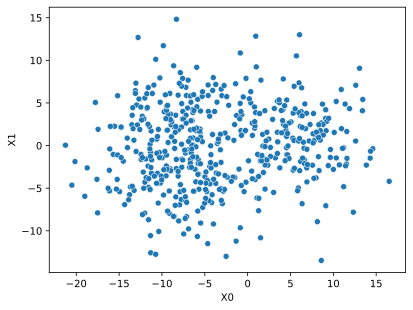

In [77]:
# Generate sample data
#note that y denotes group membership, something we are trying to predict
X,y=make_blobs(n_samples=NUMB_SAMPLES,
              n_features=2,
              centers=K_CLUSTERS,
              cluster_std=4.0,
              shuffle=True,
              random_state=RANDOM_STATE)

#place in DataFrame
X=pd.DataFrame(data=X, columns=["X0","X1"])
X['cluster_guess']=UNKNOWN
X.head()

#want to see them?
sns.scatterplot(data=X, x="X0",y="X1")

# K means, General Algorithm
<ol>
    <li>Randomly pick *k* centroids from sample points as initial cluster centers</li>
    <li>Assign each sample to the nearest centroid</li>
    <li>Move the centroids to the center of the samples assigned to it</li>
    <li>Repeat steps 2 and 3 until cluster membership stops changing</li>
</ol>

## Randomly pick *k* centroids from sample points as initial cluster centers

In [78]:
#get the centroids
centroids=get_random_centroids(X,K_CLUSTERS)
centroids

,cluster_number,X0,X1
0,0,-1.906133,-4.189208
1,1,-14.023940,-0.240626
2,2,-11.410085,-0.392850


In [79]:
def plot_info(X, centroids, figsize=(10,5)):
    '''
    plots the data we are trying to cluster and the centroids
    X: points to cluster (x,y)
    centroids: centers of each cluster
    '''
    fig = plt.figure(figsize=figsize);
    #notice that I'm plotting 2 scatterplots on the same figure
    sns.scatterplot(data=X,x="X0",y="X1",hue='cluster_guess', legend=False, palette=colors1);
    sns.scatterplot(data=centroids,x="X0",y="X1",s =200,hue='cluster_number', palette=colors1);

## Assign each sample to the nearest centroid then move the centroids to the mean of their assigned clusters

In [80]:
import math
def find_closest_cluster(df, centroids):
    # which cluster is this point closest to
    dsts = []  
    for _,c in centroids.iterrows():
        dsts.append(math.dist( (df[0],df[1]),(c[1],c[2])))

    #which centroid
    return (dsts.index(min(dsts)))

def find_mean(df):
    #find the mean
    return df.mean()

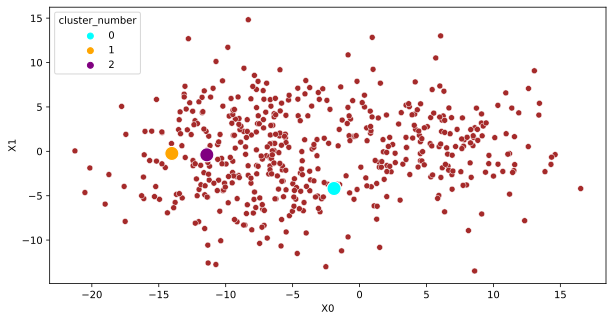

In [81]:
#lets see the original points and the initial random cluster centers
plot_info(X, centroids)

In [82]:
X.head()

,X0,X1,cluster_guess
0,-10.369706,-10.073830,-1
1,6.124840,2.240180,-1
2,-12.016596,-7.924669,-1
3,-9.037379,-2.719971,-1
4,-6.960008,-0.500539,-1


500 points changed clusters


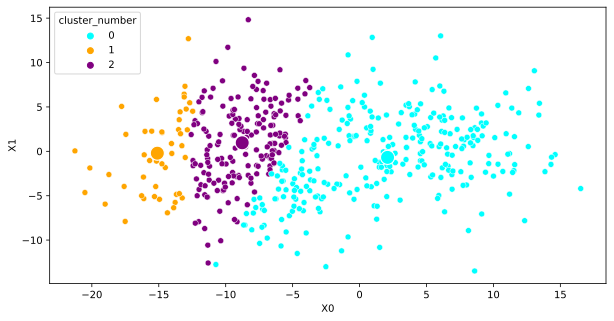

In [83]:
numb_points_changed_clusters=NUMB_SAMPLES  #assumme all change clusters to start
old=X['cluster_guess'].copy()
X['cluster_guess']=X.apply(find_closest_cluster, centroids=centroids, axis=1)  #assign points to a cluster
numb_points_changed_clusters=sum(old!=X.cluster_guess)  
print(f'{numb_points_changed_clusters} points changed clusters')

new_centroid_center = X.groupby('cluster_guess').apply(find_mean)   #get new cluster mean
centroids['X0']=new_centroid_center['X0']
centroids['X1']=new_centroid_center['X1']

plot_info(X, centroids)

## Repeat the above section until no other points change clusters

# sklearns kmeans implementation
Find sample code <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">here</a><br>
<mark>Prefer to initialize the kmeans algorithm with k-means++, this puts the initial cluster center choices as far away from each other as possible which increases the chances for convergence

## Sample use

In [84]:
#get a copy of original data
X_cpy = X.copy()

#we need a numpy array for sklearns k_means
Xnp=X_cpy.loc[:,['X0','X1']].to_numpy()

In [85]:
from sklearn.cluster import KMeans

# initialize with k-means++, this puts the initial cluster choices as far away from each other
# as possible which increases the chances for convergence
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=RANDOM_STATE)
kmeans=kmeans.fit(Xnp)

#lets see what we have
X_cpy['cluster_guess']=pd.Series(kmeans.labels_)

In [86]:
#once fitted you can predict what clusters new data would belong too
kmeans.predict([[0,0],[-7.5,3]])

array([1, 2], dtype=int32)

In [87]:
#and see what clusters all the fitted data belong to
kmeans.labels_

array([0, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 1, 1, 2,
       1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 0,
       0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1, 0,
       2, 0, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2,
       0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 2, 1,
       1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0, 0, 1, 2,
       0, 0, 0, 0, 2, 0, 2, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 1, 2, 0,
       0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1,
       1, 2, 1, 0, 2, 1, 2, 0, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 2,
       0, 0, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1,
       2, 1, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1,
       0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, 2, 1, 1,
       1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 1, 2, 2, 1, 1,

In [88]:
#where are the cluster centers?
kmeans.cluster_centers_

array([[-8.5762218 , -4.39806153],
       [ 5.70878825,  0.68759027],
       [-7.86221249,  3.97877243]])

In [89]:
#convert cluster centers to dataframe to use the above plotting function
centroids1=pd.DataFrame(data=kmeans.cluster_centers_, columns=['X0', 'X1'])
centroids1.reset_index( inplace=True)
centroids1.rename(columns={'index':'cluster_number'}, inplace=True)
centroids1

,cluster_number,X0,X1
0,0,-8.576222,-4.398062
1,1,5.708788,0.687590
2,2,-7.862212,3.978772


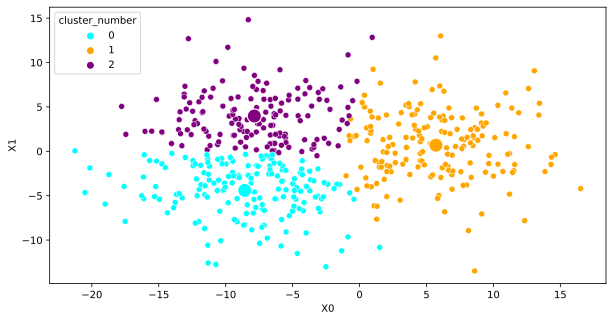

In [90]:
plot_info(X_cpy, centroids1)

## Inertia: For each cluster, square the sum of the distance between every point in that particular cluster and the cluster centroid.  Add these cluster sums together. 
![](./SSEKmeans.png)

What good is it? It helps you calculate the correct number of clusters for one

In [91]:
#the inertia for the above sklearn implementation
kmeans.inertia_

13438.337280400412

## The elbow method, used to find optimal number of clusters for kmeans
Calculate the inertia for different number of clusters.  As the number of clusters increase the inertia will decrease ( more clusters means each cluster is smaller so the SSE will also be smaller given that the points will also be closer to cluster centers)<br>
The idea is to identify the value of K where the inertia starts to rapidly increase. This means that the clusters are aquiring member points that are further and further away.

In [92]:
# First  get the inertias for various K's
inertias=[]
for k in range (1,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=RANDOM_STATE).fit(Xnp)
    inertias.append(kmeans.inertia_)


In [93]:
inertias

[41533.235634024735,
 18681.754152746726,
 13438.337280400412,
 10635.347735667881,
 8660.893164985333,
 7591.525361734462,
 6541.587246325058,
 5803.459526558665,
 5266.2171828097225,
 4801.554930778902]

Text(0, 0.5, 'Inertia')

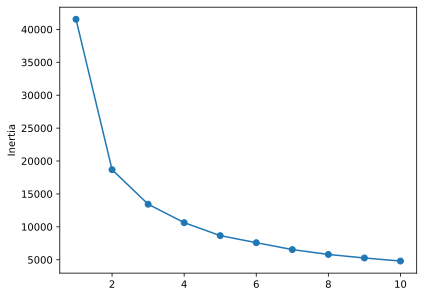

In [94]:
#then plot them
fig, ax = plt.subplots()

plt.plot( range(1,11), inertias, marker='o')
# ax.annotate('looks OK', xy=(3, 800), xytext=(4, 1500),
#             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel=('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### Unfortunately the elbow method (and following silhouette plots) are often ambiguous when the clusters are not linearly seperable

Increase the cluster_std param from 1.0 to 3.0 or 4.0 in make_blobs so the clusters are no longer linearly seperable.  Then rerun the elbow method

## Silhouette Plots, a way to visually evaluate the quality of clustering (works with other cluster methods as well)
Since it works with all distance based clustering methods,  see the reference on class website titled 'Selecting the number of clusters with silhouette analysis' for explanation and use

In [95]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [96]:

# get average silhoutte for various K's
silhouette_avgs=[]
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=RANDOM_STATE).fit(Xnp)
    print(f"for {k} clusters, silhouette_score={silhouette_score(Xnp, list(kmeans.labels_))}")
    # silhouette_avgs.append(silhouette_score(Xnp, kmeans.labels_))

for 2 clusters, silhouette_score=0.48190022949595057
for 3 clusters, silhouette_score=0.4039721680208938


for 4 clusters, silhouette_score=0.38635963391467953
for 5 clusters, silhouette_score=0.34968796563774834
for 6 clusters, silhouette_score=0.34087779642729926
for 7 clusters, silhouette_score=0.3374687945165382
for 8 clusters, silhouette_score=0.34055260086705924
for 9 clusters, silhouette_score=0.33400806901616914
for 10 clusters, silhouette_score=0.33735686557102496
